In [97]:
pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  Ã— python setup.py egg_info did not run successfully.
  â”‚ exit code: 1
  â•°â”€> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

Ã— Encountered error while generating package metadata.
â•°â”€> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [98]:
import pandas as pd
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

In [99]:
# checking duplicates
df.duplicated().sum()

np.int64(3854)

In [100]:
df.shape

(100000, 9)

In [101]:
df = df.drop_duplicates()
df.shape

(96146, 9)

In [102]:
# checking missing values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [103]:
df['gender'].value_counts()

gender
Female    56161
Male      39967
Other        18
Name: count, dtype: int64

In [104]:
df['smoking_history'].value_counts()

smoking_history
never          34398
No Info        32887
former          9299
current         9197
not current     6367
ever            3998
Name: count, dtype: int64

In [105]:
# checking data types
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [106]:
# train test splitting
from sklearn.model_selection import train_test_split
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((76916, 8), (19230, 8))

### Peform explanatory data analysis with train data

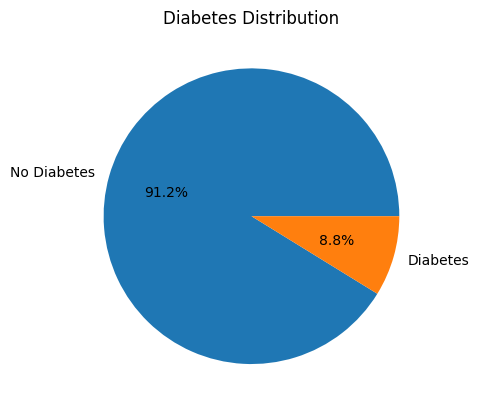

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.pie(y_train.value_counts(), labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%')
plt.title('Diabetes Distribution')
plt.show()

The response variable is perform class imbalanced, so we need to take into account in advanced analysis process.

In [108]:
X_train.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level'],
      dtype='object')

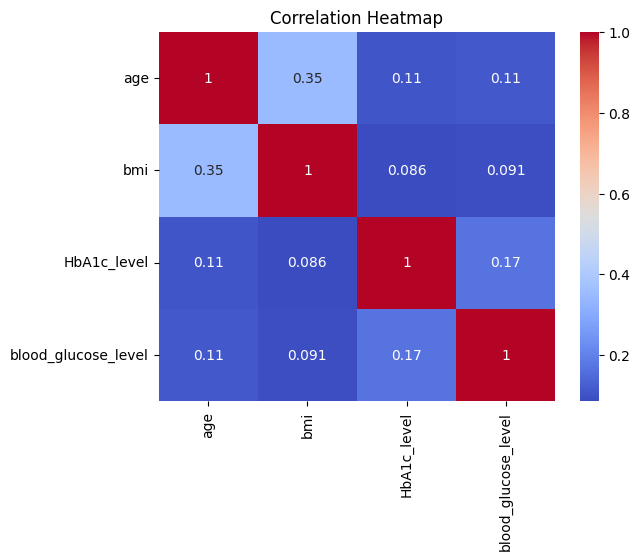

In [109]:
num_cols = ['age','bmi','HbA1c_level','blood_glucose_level']
sns.heatmap(X_train[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Not perform severe multicolinearity between numerical predictor variables.

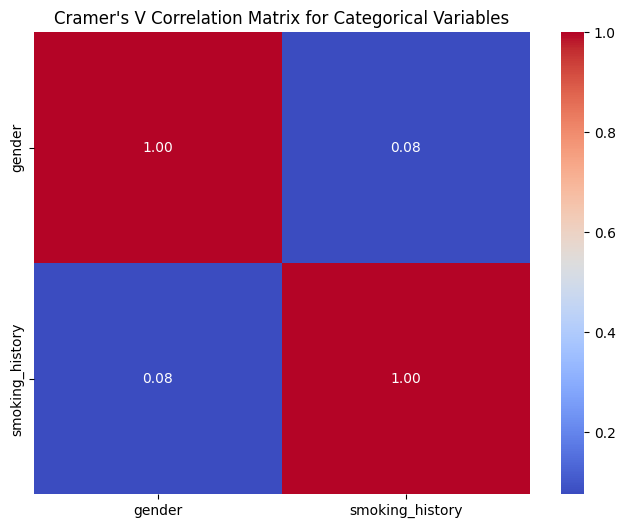

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Identify categorical columns
categorical_cols = ['gender', 'smoking_history']

# Calculate Cramer's V matrix
cramers_v_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix.astype(float), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cramer's V Correlation Matrix for Categorical Variables")
plt.show()

Distribution of numerical variables

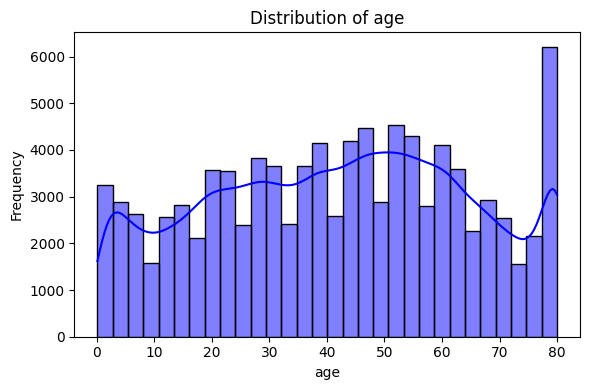

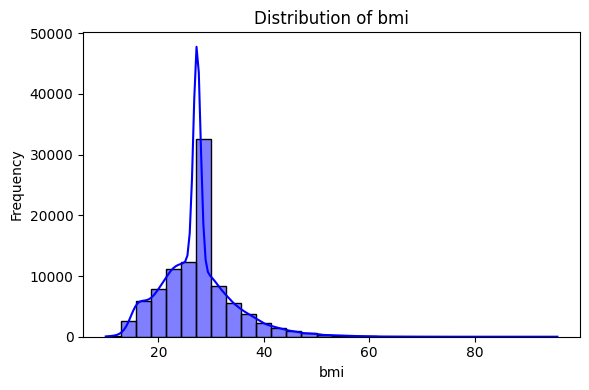

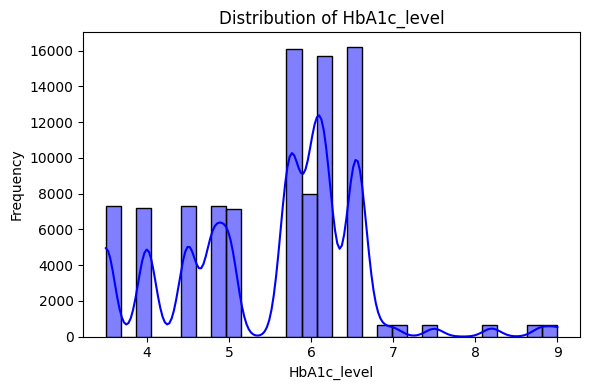

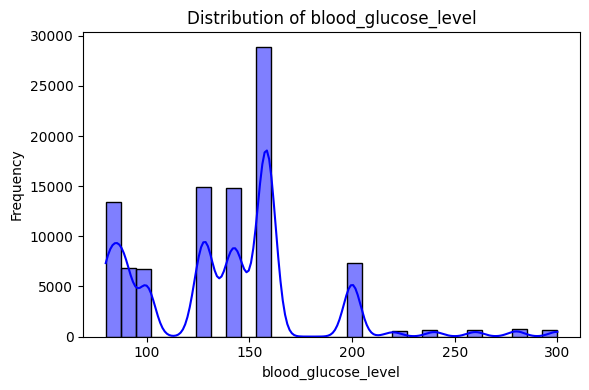

In [111]:
num_cols = ['age','bmi','HbA1c_level','blood_glucose_level']
for i in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[i], kde=True, bins=30, color='blue', edgecolor='black')
    plt.title(f'Distribution of {i}')
    plt.xlabel(i)
    plt.ylabel('Frequency')
    #plt.grid(True)
    plt.tight_layout()
    plt.show()

Distribution of categorical Variables

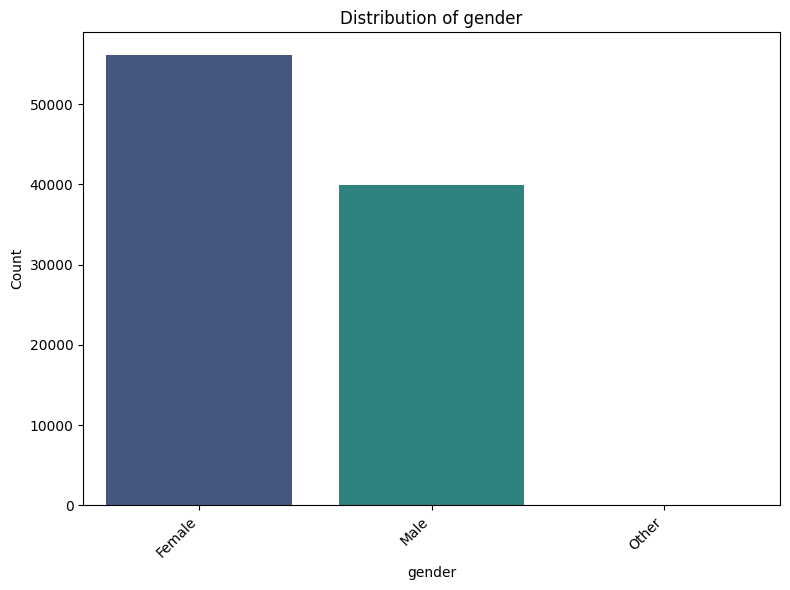

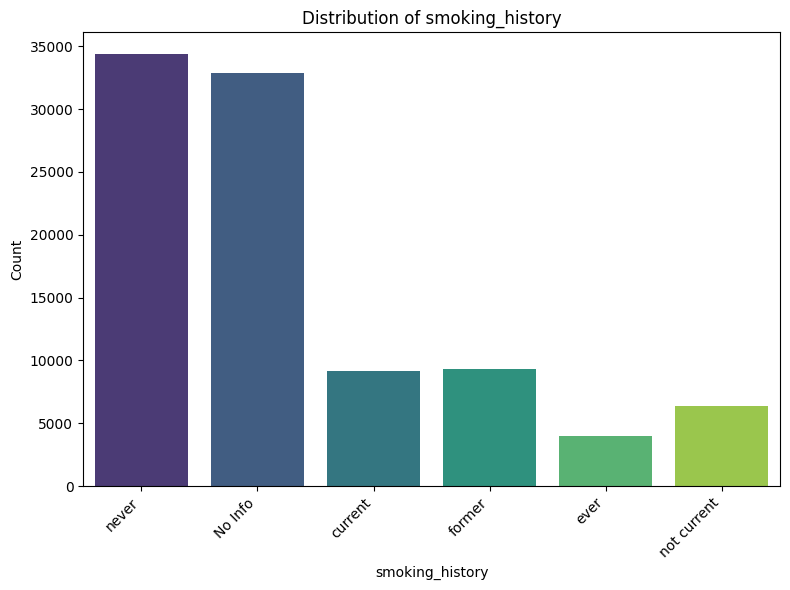

In [112]:
categorical_cols_to_plot = ['gender', 'smoking_history']

for col in categorical_cols_to_plot:
    plt.figure(figsize=(8, 6))
    # Use the original df for plotting categorical variables
    if col in ['gender', 'smoking_history']:
        sns.countplot(data=df, x=col, palette='viridis', hue=col, legend=False)
    else:
        sns.countplot(data=X_train, x=col, palette='viridis', hue=col, legend=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [113]:
print(df['hypertension'].value_counts())
print(df['heart_disease'].value_counts())


hypertension
0    88685
1     7461
Name: count, dtype: int64
heart_disease
0    92223
1     3923
Name: count, dtype: int64


In [114]:
pip install prince

In [115]:
import prince
FAMD = prince.FAMD(n_components=5)
FAMD_Data = FAMD.fit_transform(X_train)
display(FAMD_Data.head())


component         0         1         2         3         4
46612     -1.199886 -0.419130  0.240764 -1.107271  1.138911
31612     -2.660132  1.200275 -0.070308 -0.633609 -2.219231
96143      0.270366 -1.730581  0.744299  6.183669  1.247876
95691     -0.049672  0.420635 -0.602780 -0.816332 -1.635881
37658      0.051578  1.504658  4.423681  1.543867 -0.746633

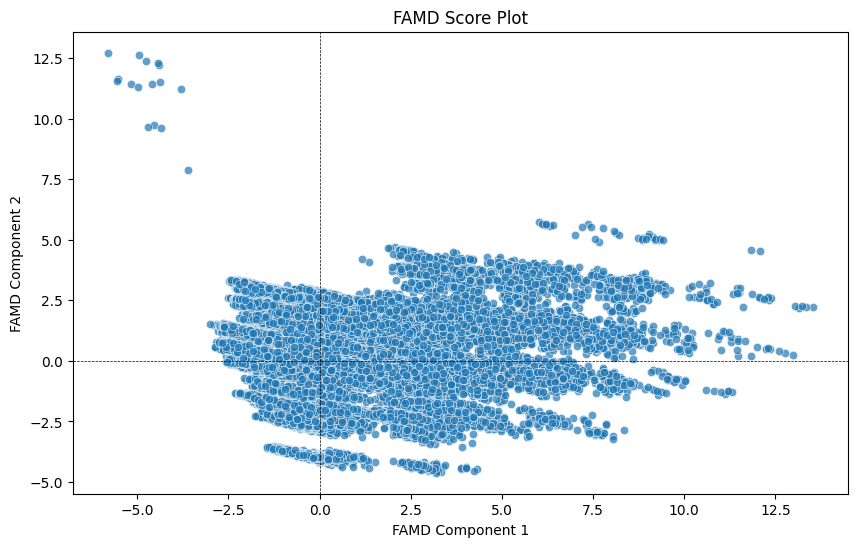

In [116]:
# Plotting FAMD score plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=FAMD_Data.iloc[:, 0], y=FAMD_Data.iloc[:, 1], alpha=0.7)

plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.axvline(0, color="black", linestyle="--", linewidth=0.5)
plt.xlabel("FAMD Component 1")
plt.ylabel("FAMD Component 2")
plt.title("FAMD Score Plot")
plt.show()

According to factor analysis for mixed data we could not detect any clusters here. to make sence that i decided to perform silhoutte method below.

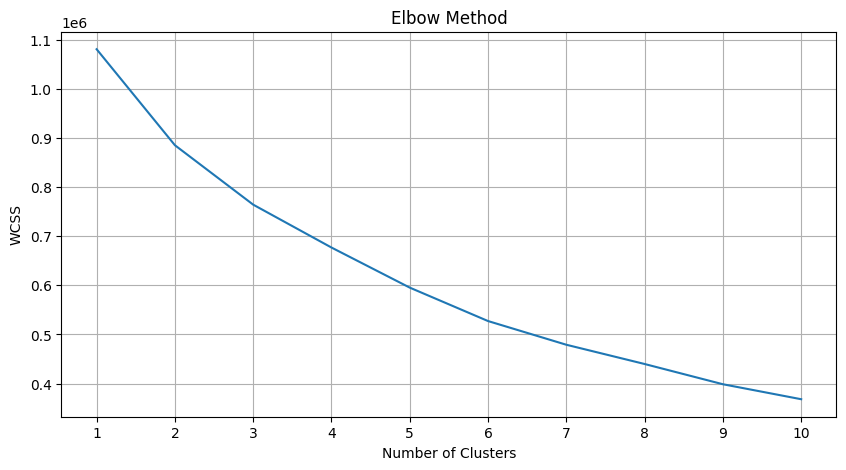

In [117]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming FAMD_Data is your data for clustering
# If you want to use the scaled data, replace FAMD_Data with X_train (after scaling)
data_for_clustering = FAMD_Data

# Elbow Method to find the optimal number of clusters
wcss = [] # Within-cluster sum of squares
for i in range(1, 11): # Trying 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(data_for_clustering)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()



In [118]:
# apply encoding - label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_train['gender'] = le.fit_transform(X_train['gender'])
X_train['smoking_history'] = le.fit_transform(X_train['smoking_history'])
X_train.head()


gender   age  hypertension  heart_disease  smoking_history    bmi  \
46612       0  35.0             0              0                0  31.53   
31612       0   0.4             0              0                0  15.19   
96143       0  60.0             0              0                2  20.90   
95691       1  66.0             0              0                4  27.05   
37658       1  48.0             0              0                5  24.05   

       HbA1c_level  blood_glucose_level  
46612          6.6                  155  
31612          4.0                  130  
96143          6.5                  100  
95691          6.0                  130  
37658          4.8                  145

Handle class imbalnced

In [119]:
# reduce class imbalance
from imblearn.over_sampling import SMOTE

# Apply SMOTE on the standardized data
# Set n_neighbors to a value less than or equal to the minimum number of samples in any class
smote = SMOTE(random_state=42, k_neighbors=5)
x_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)


print("Shape of original c1_x_train:", X_train.shape)
print("Shape of c1_y_train:",y_train.shape)
print("Shape of c1_x_train after scaling and SMOTE:", x_train_smote.shape)
print("Shape of c1_y_train after scaling and SMOTE:", y_train_smote.shape)
print("\nValue counts of original c1_y_train:")
print(y_train.value_counts())
print("\nValue counts of c1_y_train after SMOTE:")
print(y_train_smote.value_counts())

Shape of original c1_x_train: (76916, 8)
Shape of c1_y_train: (76916,)
Shape of c1_x_train after scaling and SMOTE: (140310, 8)
Shape of c1_y_train after scaling and SMOTE: (140310,)

Value counts of original c1_y_train:
diabetes
0    70155
1     6761
Name: count, dtype: int64

Value counts of c1_y_train after SMOTE:
diabetes
0    70155
1    70155
Name: count, dtype: int64


In [120]:
# apply scalling - Standard scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_train.head()

gender       age  hypertension  heart_disease  smoking_history       bmi  \
0 -0.842551 -0.301980     -0.288976       -0.20548        -1.184402  0.624051   
1 -0.842551 -1.842405     -0.288976       -0.20548        -1.184402 -1.789284   
2 -0.842551  0.811043     -0.288976       -0.20548        -0.120243 -0.945946   
3  1.184843  1.078169     -0.288976       -0.20548         0.943916 -0.037623   
4  1.184843  0.276792     -0.288976       -0.20548         1.475995 -0.480707   

   HbA1c_level  blood_glucose_level  
0     0.994649             0.412328  
1    -1.428149            -0.198580  
2     0.901465            -0.931669  
3     0.435542            -0.198580  
4    -0.682673             0.167965

Applying same preprocessing for test data

In [121]:
X_test.head()

gender   age  hypertension  heart_disease smoking_history    bmi  \
2547   Female   5.0             0              0         No Info  15.14   
34774    Male  19.0             0              0           never  22.74   
71084  Female  52.0             0              0           never  24.27   
50584    Male  55.0             0              0         No Info  27.32   
80788  Female  22.0             0              0           never  28.78   

       HbA1c_level  blood_glucose_level  
2547           4.5                   90  
34774          6.6                   85  
71084          7.5                  220  
50584          5.7                   85  
80788          4.5                  200

In [122]:
X_test['gender'] = le.fit_transform(X_test['gender'])
X_test['smoking_history'] = le.fit_transform(X_test['smoking_history'])
X_test.head()


gender   age  hypertension  heart_disease  smoking_history    bmi  \
2547        0   5.0             0              0                0  15.14   
34774       1  19.0             0              0                4  22.74   
71084       0  52.0             0              0                4  24.27   
50584       1  55.0             0              0                0  27.32   
80788       0  22.0             0              0                4  28.78   

       HbA1c_level  blood_glucose_level  
2547           4.5                   90  
34774          6.6                   85  
71084          7.5                  220  
50584          5.7                   85  
80788          4.5                  200

In [123]:
X_test_scaled = sc.fit_transform(X_test)
X_test = pd.DataFrame(X_test_scaled,columns=X_test.columns)
X_test.head()

gender       age  hypertension  heart_disease  smoking_history       bmi  \
0 -0.84710 -1.639615     -0.294321      -0.209294        -1.196552 -1.813199   
1  1.17949 -1.016528     -0.294321      -0.209294         0.928907 -0.688126   
2 -0.84710  0.452179     -0.294321      -0.209294         0.928907 -0.461631   
3  1.17949  0.585698     -0.294321      -0.209294        -1.196552 -0.010122   
4 -0.84710 -0.883009     -0.294321      -0.209294         0.928907  0.206011   

   HbA1c_level  blood_glucose_level  
0    -0.961862            -1.189220  
1     0.994219            -1.311604  
2     1.832539             1.992771  
3     0.155898            -1.311604  
4    -0.961862             1.503234

### Fitting a machine learning model for SMOTE data ( after handling class imbalaned

decision Tree Classifier


In [124]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the model
dt = DecisionTreeClassifier(
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    class_weight='balanced'  # Optional: good if some classes are rare
)
dt.fit(x_train_smote, y_train_smote)

# Make predictions
y_train_pred = dt.predict(x_train_smote)
y_test_pred = dt.predict(X_test)

# Evaluate on Training Data
print("ðŸ“Š Confusion Matrix (Train):")
print(confusion_matrix(y_train_smote, y_train_pred))

print("\nðŸ“Š Classification Report (Train):")
print(classification_report(y_train_smote, y_train_pred))

# Evaluate on Test Data
print("\nðŸ“Š Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nðŸ“Š Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

ðŸ“Š Confusion Matrix (Train):
[[70152     3]
 [   47 70108]]

ðŸ“Š Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70155
           1       1.00      1.00      1.00     70155

    accuracy                           1.00    140310
   macro avg       1.00      1.00      1.00    140310
weighted avg       1.00      1.00      1.00    140310


ðŸ“Š Confusion Matrix (Test):
[[17509     0]
 [ 1721     0]]

ðŸ“Š Classification Report (Test):
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     17509
           1       0.00      0.00      0.00      1721

    accuracy                           0.91     19230
   macro avg       0.46      0.50      0.48     19230
weighted avg       0.83      0.91      0.87     19230



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


random forest

In [125]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'  # Optional: good if some classes are rare
)
rf.fit(x_train_smote, y_train_smote)

# Make predictions
y_train_pred = rf.predict(x_train_smote)
y_test_pred = rf.predict(X_test)

# Evaluate on Training Data
print("ðŸ“Š Confusion Matrix (Train):")
print(confusion_matrix(y_train_smote, y_train_pred))

print("\nðŸ“Š Classification Report (Train):")
print(classification_report(y_train_smote, y_train_pred))

# Evaluate on Test Data
print("\nðŸ“Š Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nðŸ“Š Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

ðŸ“Š Confusion Matrix (Train):
[[70140    15]
 [   35 70120]]

ðŸ“Š Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70155
           1       1.00      1.00      1.00     70155

    accuracy                           1.00    140310
   macro avg       1.00      1.00      1.00    140310
weighted avg       1.00      1.00      1.00    140310


ðŸ“Š Confusion Matrix (Test):
[[17509     0]
 [ 1721     0]]

ðŸ“Š Classification Report (Test):
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     17509
           1       0.00      0.00      0.00      1721

    accuracy                           0.91     19230
   macro avg       0.46      0.50      0.48     19230
weighted avg       0.83      0.91      0.87     19230



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [126]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf, x_train_smote, y_train_smote, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())
print("Standard deviation of cross-validation accuracy:", cv_scores.std())

Cross-validation scores: [0.93991875 0.9797591  0.98064999 0.98057872 0.97940275]
Mean cross-validation accuracy: 0.9720618630176039
Standard deviation of cross-validation accuracy: 0.016078610255445092


In [127]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_cv_cm = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

# Get cross-validated predictions
y_train_smote_pred_cv = cross_val_predict(rf_cv_cm, x_train_smote, y_train_smote, cv=5)

# Calculate confusion matrix using the cross-validated predictions
cm_cv = confusion_matrix(y_train_smote, y_train_smote_pred_cv)


# Evaluate on Training Data
print("ðŸ“Š Confusion Matrix (Train):")
print(cm_cv)

print("\nðŸ“Š Classification Report (Train):")
print(classification_report(y_train_smote, y_train_smote_pred_cv))



ðŸ“Š Confusion Matrix (Train):
[[68319  1836]
 [ 2084 68071]]

ðŸ“Š Classification Report (Train):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     70155
           1       0.97      0.97      0.97     70155

    accuracy                           0.97    140310
   macro avg       0.97      0.97      0.97    140310
weighted avg       0.97      0.97      0.97    140310



In [128]:
# Get cross-validated predictions
y_test_smote_pred_cv = cross_val_predict(rf_cv_cm, X_test, y_test, cv=5)

# Calculate confusion matrix using the cross-validated predictions
cm_cv = confusion_matrix(y_test, y_test_smote_pred_cv)


# Evaluate on Training Data
print("ðŸ“Š Confusion Matrix (Test):")
print(cm_cv)

print("\nðŸ“Š Classification Report (Test):")
print(classification_report(y_test, y_test_smote_pred_cv))


ðŸ“Š Confusion Matrix (Test):
[[17467    42]
 [  541  1180]]

ðŸ“Š Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17509
           1       0.97      0.69      0.80      1721

    accuracy                           0.97     19230
   macro avg       0.97      0.84      0.89     19230
weighted avg       0.97      0.97      0.97     19230



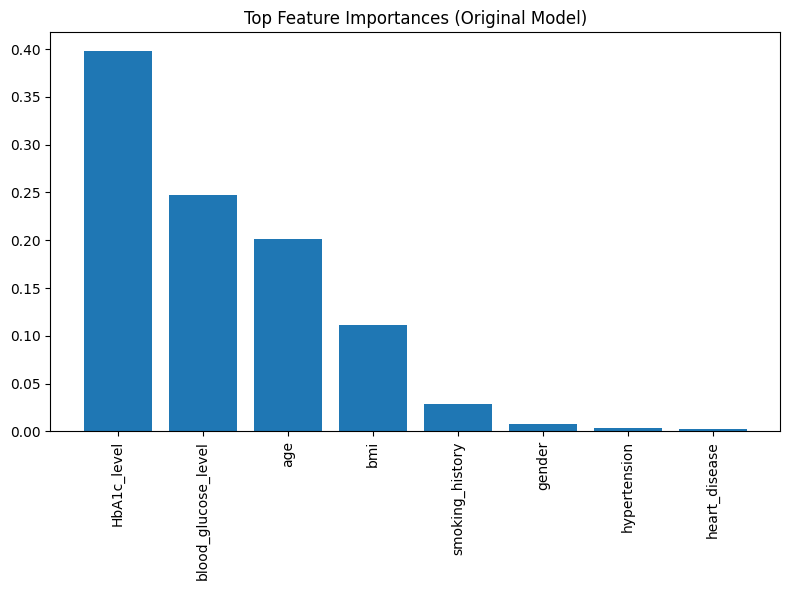

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_cv_cm = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

# Fit the model on the entire training data
rf_cv_cm.fit(x_train_smote, y_train_smote)


# Get feature importances
importances = rf_cv_cm.feature_importances_
feature_names = X.columns  # Assumes X_train is a DataFrame

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(8, 6))
plt.title("Top Feature Importances (Original Model)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

Model deplyment

In [130]:
import pickle
with open ('model_pickle','wb') as f :
    pickle.dump(rf,f)